# Import libraries

In [1]:
# Import libraries for Preprocessing and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
import math

# Libraries for Significance Test and Causal Inference
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.optimize import linear_sum_assignment
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
filepath = 'student_data.csv'
data = pd.read_csv(filepath)

# Defined function

In [6]:
# Functions for Preprocessing and EDA
# dataset summary
def summarize_dataset(df):
    """
    Generates a summary of the dataset with the following details:
    - Missing_Values: Count of missing values per column.
    - Unique_Values: Count of unique values per column.
    - Data_Type: Data type of each column.
    - Distinct_Values_Sample: A sample of the first 5 unique non-missing values for each column.
    """
    summary = pd.DataFrame({
        'Missing_Values': data.isna().sum(),
        'Unique_Values': data.nunique(),
        'Data_Type': data.dtypes,
        'Distinct_Values_Sample': data.apply(lambda x: x.dropna().unique()[:5].tolist())  # First 5 unique values
    }).reset_index()

    summary.rename(columns={'index': 'Column_Name'}, inplace=True)
    return summary


# histogram for all variables
def plot_hist_numeric(data):
    """
    Plots histograms for all numeric columns in the dataset.

    Parameters:
    - data: DataFrame containing the dataset.
    
    Output:
    - Displays histograms with KDE (Kernel Density Estimate) for each numeric column.
    """
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    fig, axes = plt.subplots(4, 4, figsize=(20, 15)) 
    axes = axes.flatten() 

    for i, col in enumerate(numeric_data.columns):
        sns.histplot(data[col], kde=False, bins=30, ax=axes[i])
        patches = axes[i].patches
        colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
        for patch, color in zip(patches, colors):
            patch.set_facecolor(color)
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Frequency/Density', fontsize=10)

    if len(numeric_data.columns) < len(axes):
        for j in range(len(numeric_data.columns), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

# Pie chart for all categorical variables
def plot_categorical_pie_charts(data, n_rows=3, n_cols=6, figsize=(18, 10)):
    """
    Plots pie charts for all categorical columns in the dataset.

    Parameters:
    - data: DataFrame containing the dataset.
    - n_rows: Number of rows for the subplot grid (default=3).
    - n_cols: Number of columns for the subplot grid (default=6).
    - figsize: Size of the overall figure (default=(18, 10)).
    
    Output:
    - Displays pie charts for each categorical column.
    """
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
    num_plots = len(categorical_cols)

    total_subplots = n_rows * n_cols
    if num_plots < total_subplots:
        n_rows = (num_plots + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        data[col].value_counts(normalize=True).plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            colors=plt.cm.Paired.colors,
            ax=axes[i],
            labeldistance=None
        )
        axes[i].set_title(f'{col} Distribution', fontsize=10)
        axes[i].set_ylabel('')
        axes[i].legend(
            loc='upper left',
            labels=data[col].value_counts().index.astype(str),
            fontsize=8
        )

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# function for heatmap
def plot_heatmap(df):
    """
    Plots a heatmap of the correlation matrix of numerical features in the dataset using matplotlib.
    
    Args:
    df (DataFrame): The input dataframe for analysis.
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 8))
    cax = ax.matshow(corr, cmap='coolwarm')
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Heatmap of Correlation Matrix', pad=20)
    plt.show()

# correlation importance
def plot_feature_importance(df, target_column):
    """
    Plots the feature importance of the dataset using a Random Forest classifier.
    
    Args:
    df (DataFrame): The input dataframe for analysis.
    target_column (str): The name of the target column.
    """
    # Preprocess the data
    label_encoder = LabelEncoder()
    if df[target_column].dtype == 'object':
        df[target_column] = label_encoder.fit_transform(df[target_column])
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fit RandomForestClassifier to find feature importance
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.axvline(x=0.04, color='red', linestyle='--', label='Threshold = 0.04')
    sns.barplot(x=feature_importances_sorted, y=feature_importances_sorted.index, palette='viridis')
    plt.title('Feature Importance based on RandomForest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# function for heatmap with the specific correlation values
def heatmap_detail(data):
    """
    Plots a heatmap displaying the correlation matrix for numerical features in the dataset.

    Parameters:
    - data: DataFrame containing the dataset.

    Output:
    - A heatmap with annotations showing the correlation coefficients.
    """
    correlation_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.xticks(rotation=30)
    plt.title("Heatmap of Correlation Matrix")
    plt.show()

# Data Preprocessing

In [9]:
# Rename columns
data = data.rename(columns={'school': 'School', 'sex':'Sex', 'age':'Age',
                   'address':'HomeLoc','famsize':'FamSize', 'reason':'Reason', 
                    'guardian': 'Guardian','traveltime':'TravelTime','studytime':'StudyTime',
                  'failures':'Failures','schoolsup':'SchoolSup','famsup':'FamSup','paid':'Paid',
                  'activities':'Activities','nursery':'Nursery','higher':'Higher',
                   'internet':'Internet','romantic':'Romantic','famrel':'FamRel',
                   'freetime':'FreeTime','goout':'GoOut','health':'Health','absences':'Absences'})

# EDA

In [12]:
# Generate a summary of the dataset 
dataset_summary = summarize_dataset(data)
dataset_summary

,Column_Name,Missing_Values,Unique_Values,Data_Type,Distinct_Values_Sample
0,School,0,2,object,"[GP, MS]"
1,Sex,0,2,object,"[F, M]"
2,Age,0,8,int64,"[18, 17, 15, 16, 19]"
3,HomeLoc,0,2,object,"[U, R]"
4,FamSize,0,2,object,"[GT3, LE3]"
5,Pstatus,0,2,object,"[A, T]"
6,Medu,0,5,int64,"[4, 1, 3, 2, 0]"
7,Fedu,0,5,int64,"[4, 1, 2, 3, 0]"
8,Mjob,0,5,object,"[at_home, health, other, services, teacher]"
9,Fjob,0,5,object,"[teacher, other, services, health, at_home]"


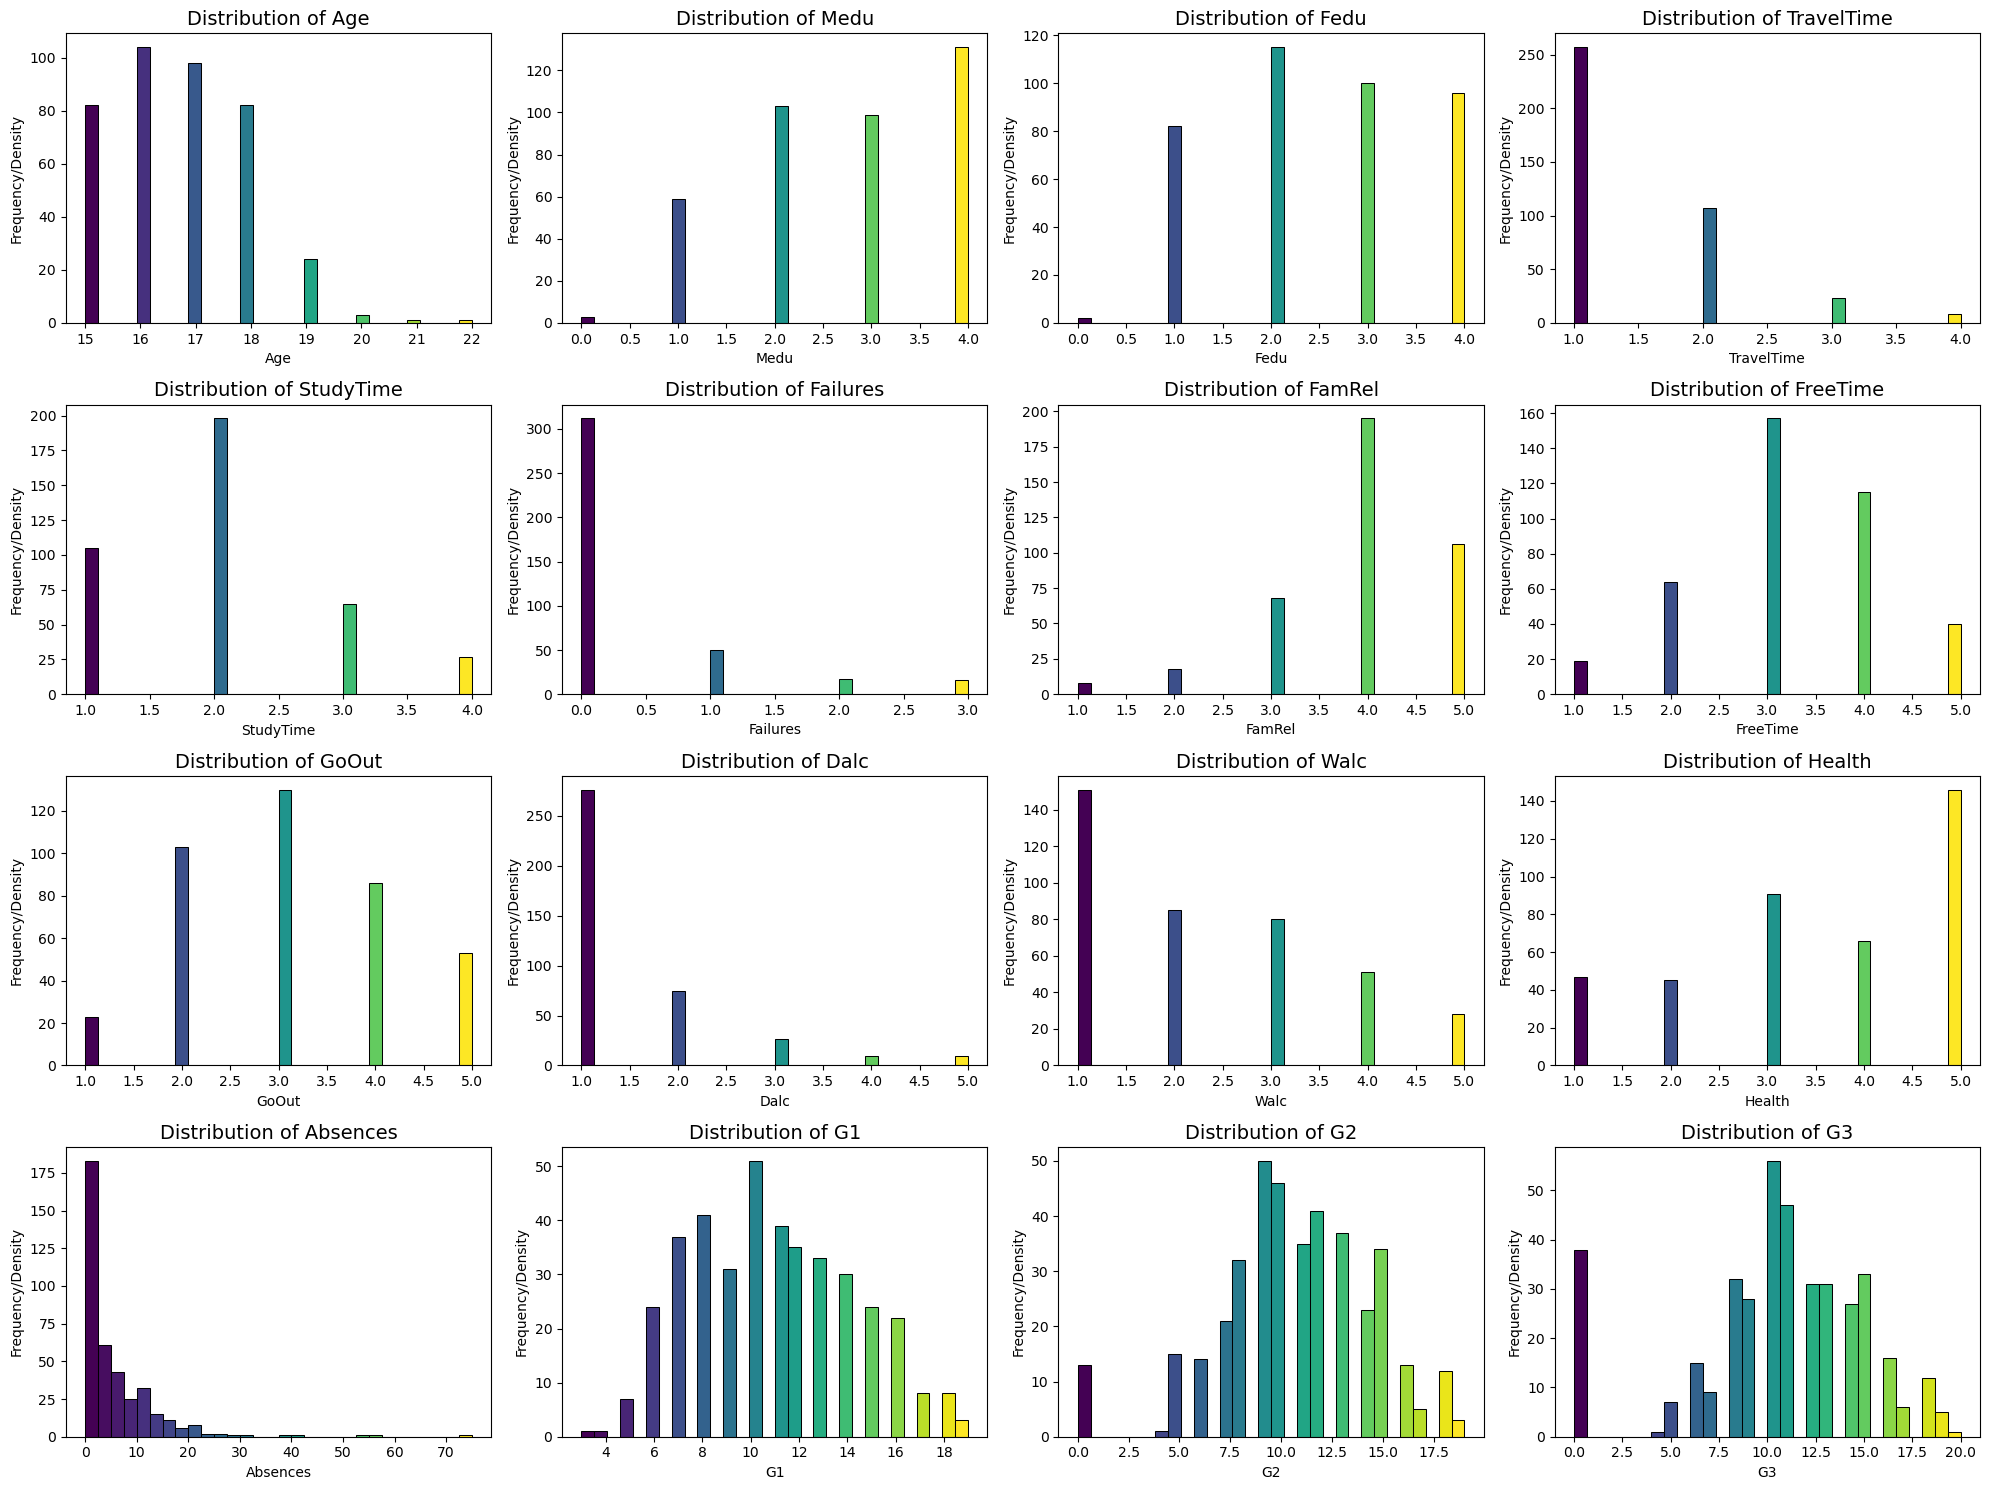

In [14]:
# Plot histograms all numerical variables
plot_hist_numeric(data)

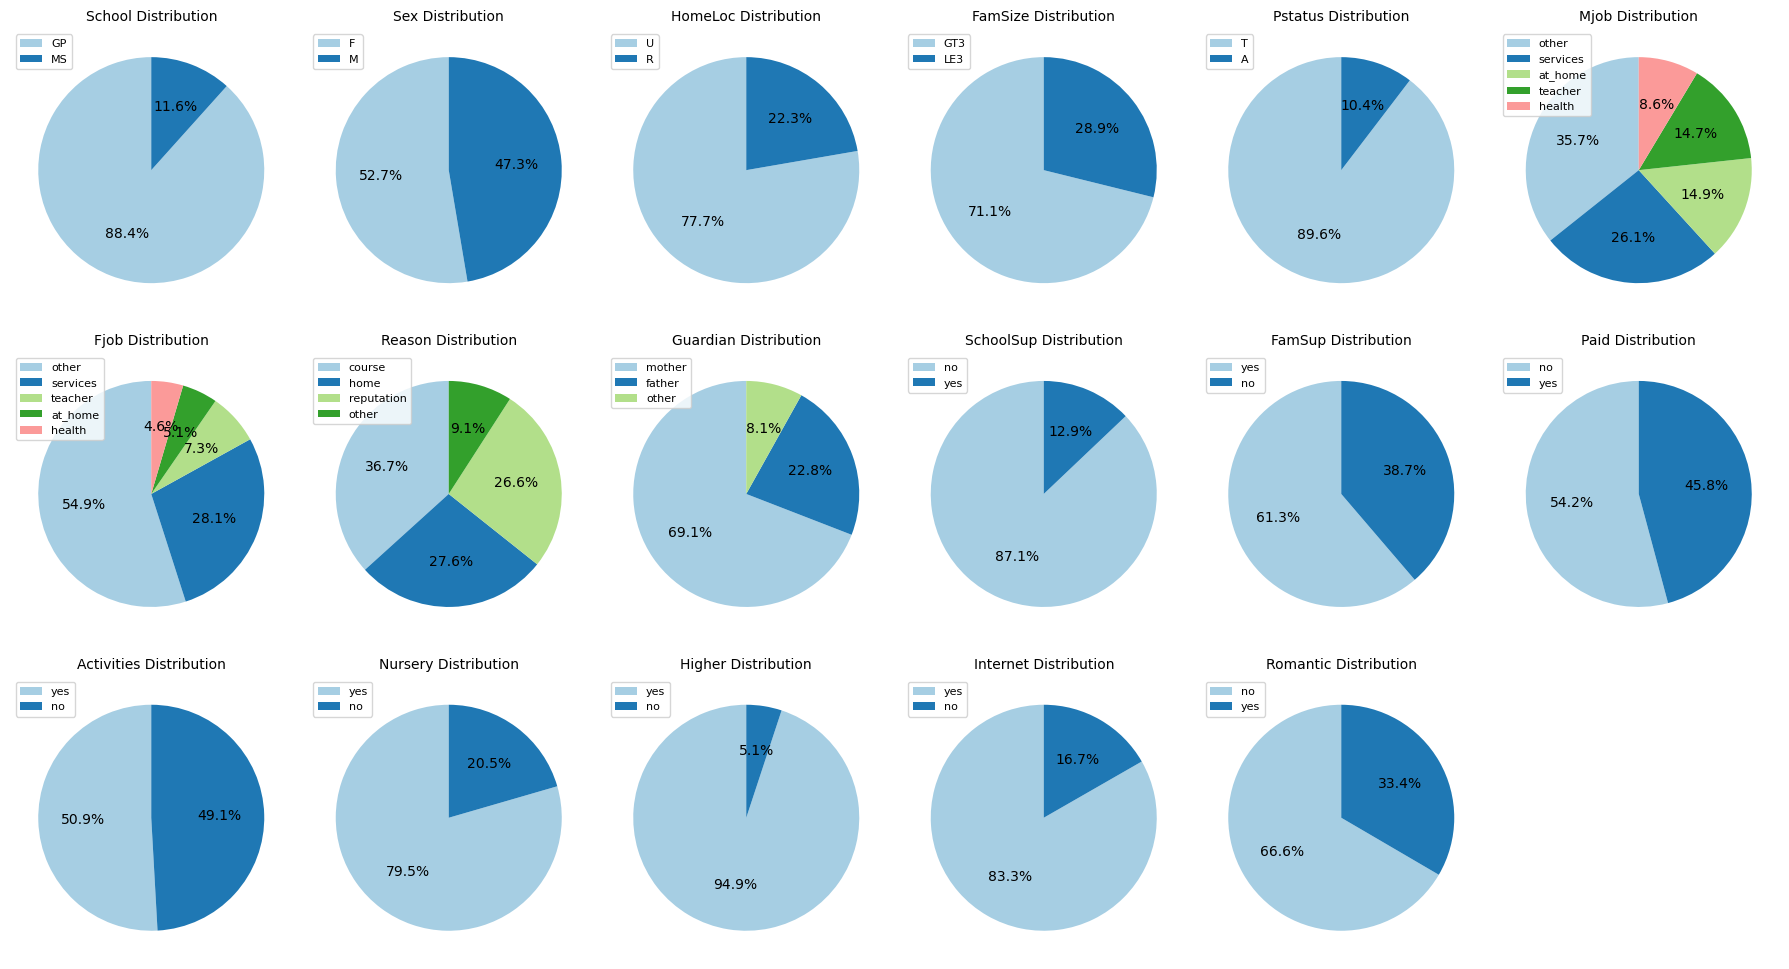

In [15]:
#Plot pie charts for all categorical variables
plot_categorical_pie_charts(data)

In [8]:
# Convert non-numeric features to numeric
non_numeric_features = data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for feature in non_numeric_features:
    data[feature] = label_encoder.fit_transform(data[feature])

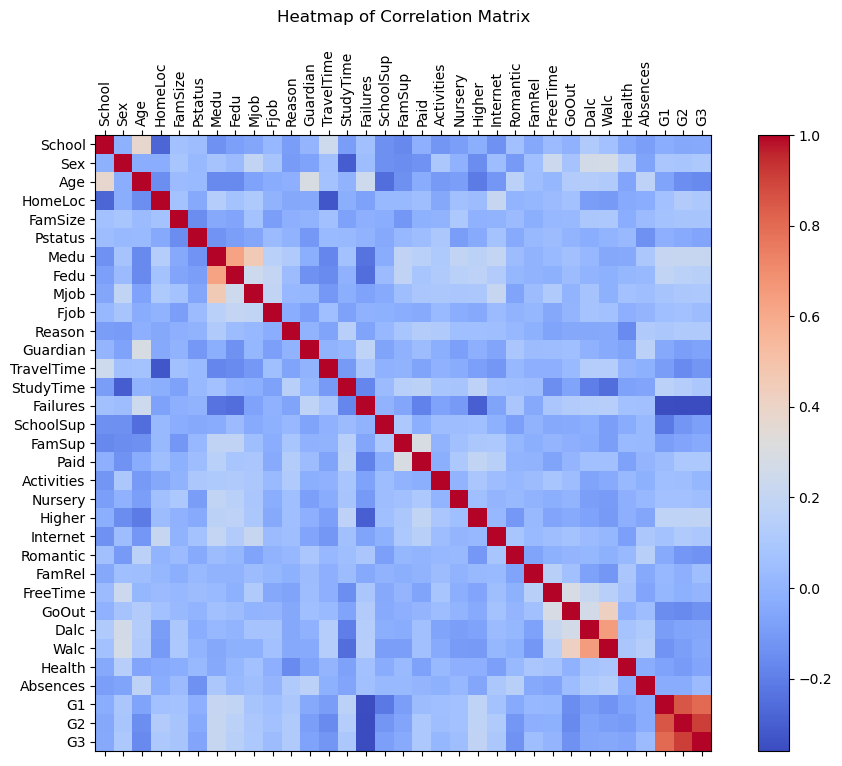

In [9]:
# Plot heatmap of correlation matrix for all variables
plot_heatmap(data)

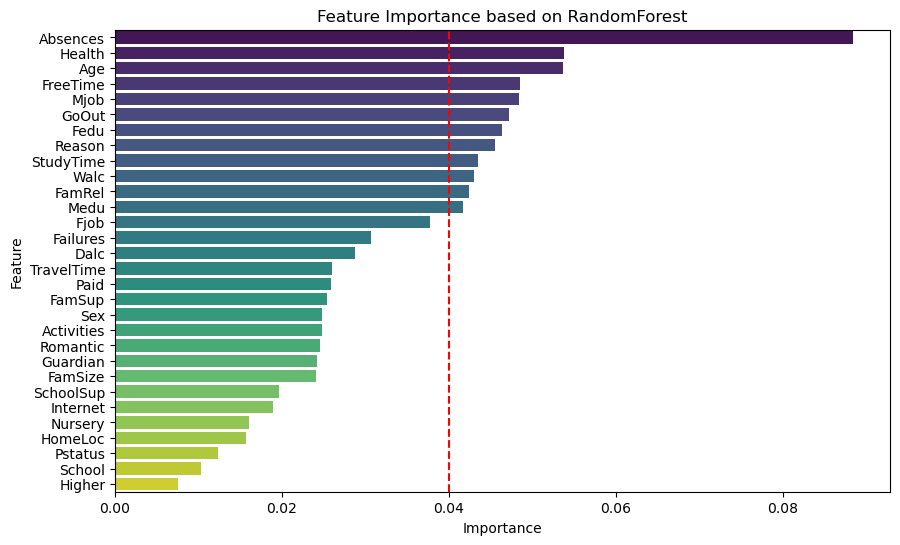

In [10]:
# Plot correlation importance using RandomForest
data_without_other_scores = data.drop(columns=["G1","G2"])
plot_feature_importance(data_without_other_scores, target_column='G3')

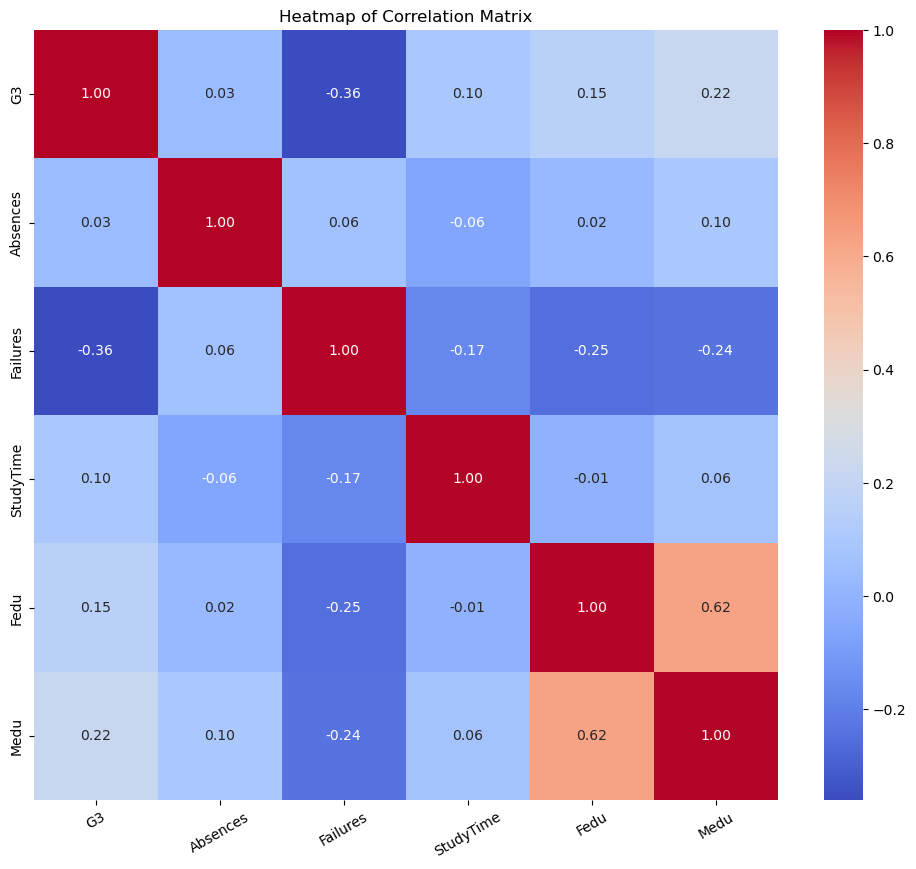

In [11]:
# List of columns you want to keep
selected_columns = ["G3", "Absences", "Failures", "StudyTime", "Fedu", "Medu"]
var = data[selected_columns]
heatmap_detail(var)

# Significance tests

Column: failures
T-Statistic: 7.0156, P-Value: 0.0000


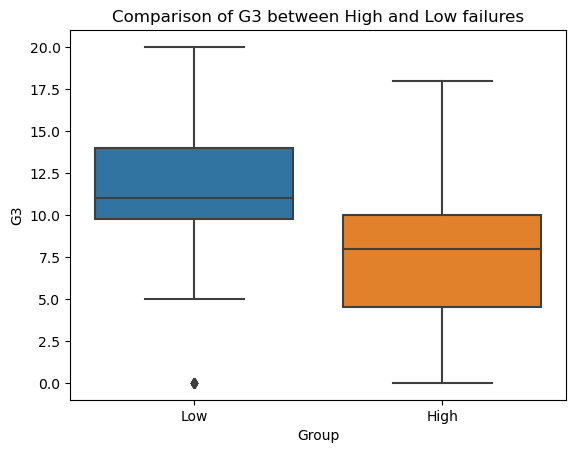

Column: absences
T-Statistic: -1.6819, P-Value: 0.0934


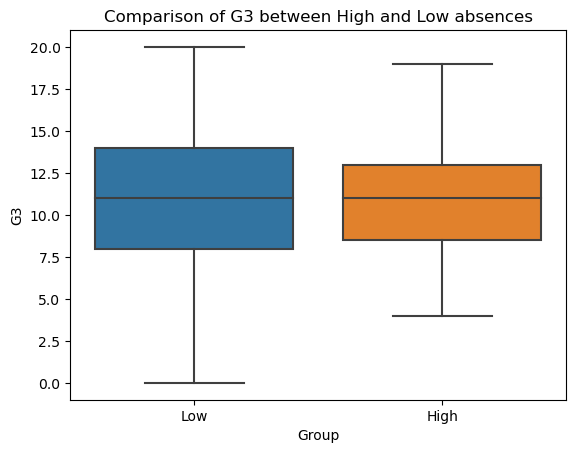

Column: age
T-Statistic: 2.7939, P-Value: 0.0058


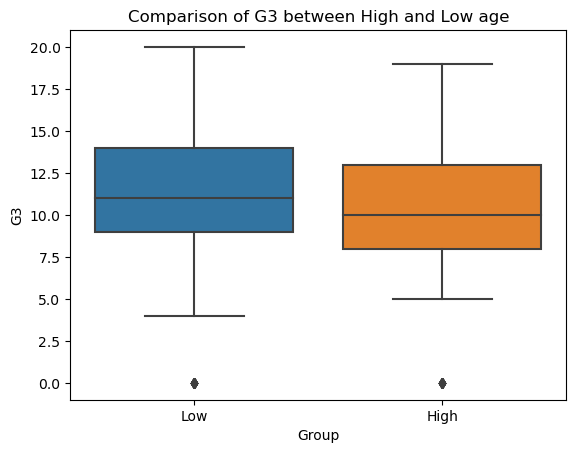

Column: health
T-Statistic: 0.0604, P-Value: 0.9519


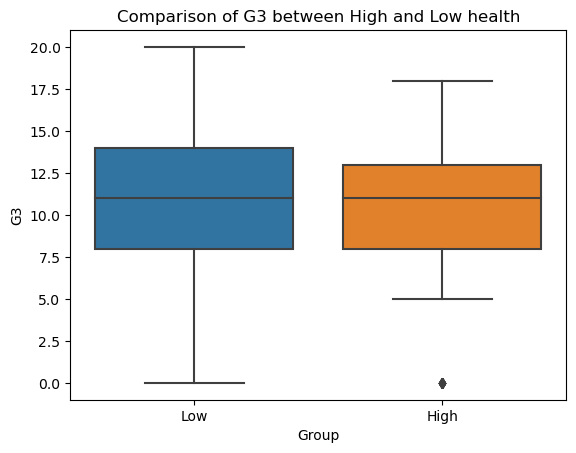

Column: freetime
T-Statistic: -0.8350, P-Value: 0.4043


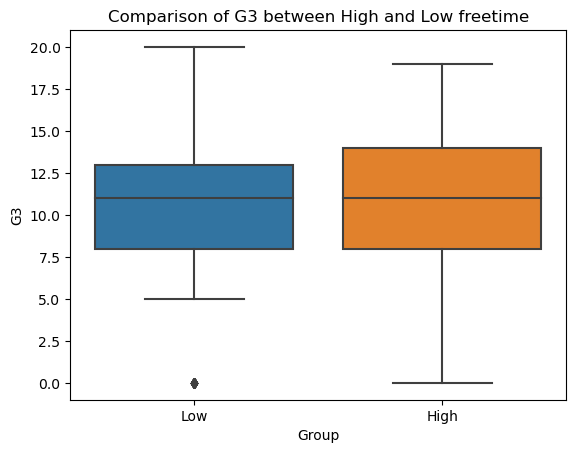

Column: goout
T-Statistic: 3.1811, P-Value: 0.0016


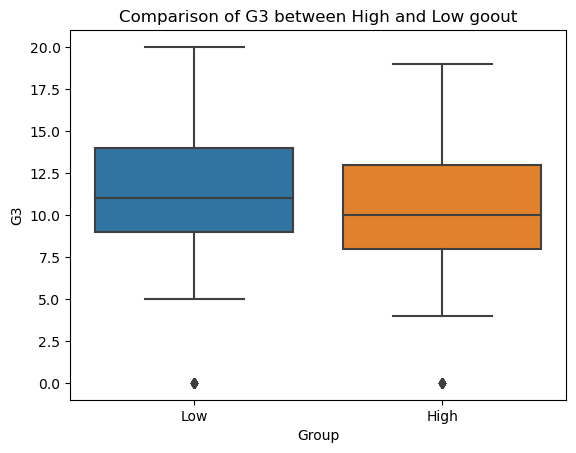

Column: Walc
T-Statistic: 0.4740, P-Value: 0.6358


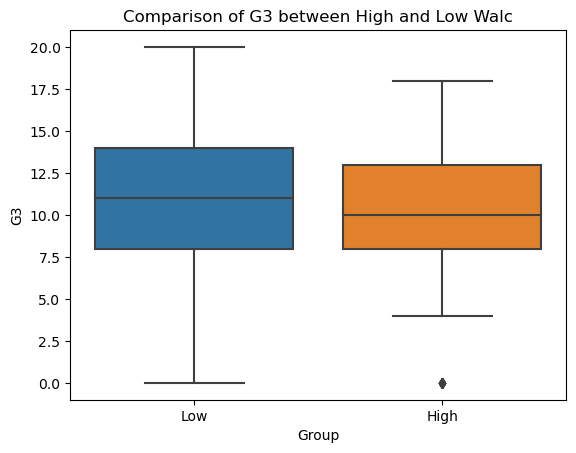

Column: Fedu
T-Statistic: -2.5587, P-Value: 0.0109


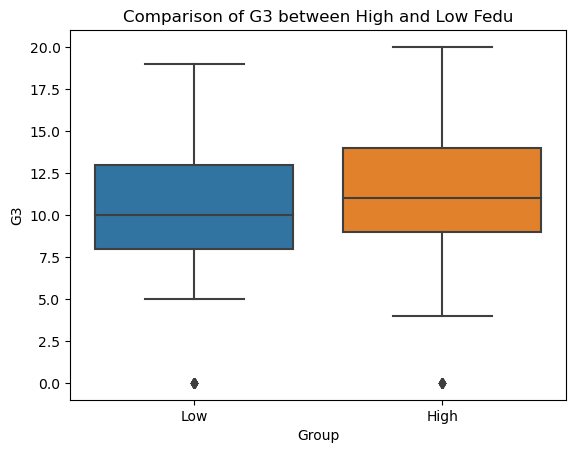

Column: Medu
T-Statistic: -4.3113, P-Value: 0.0000


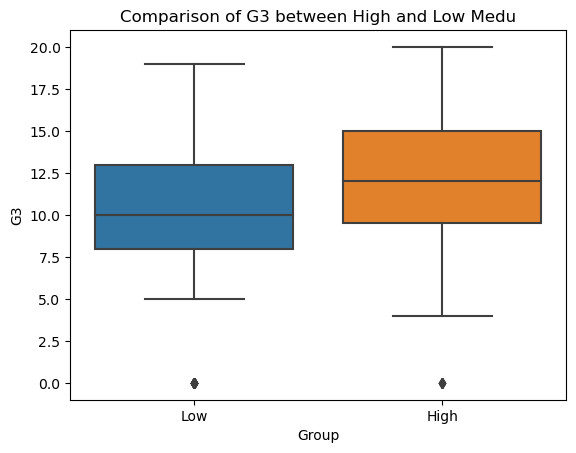

Column: famrel
T-Statistic: -1.0678, P-Value: 0.2871


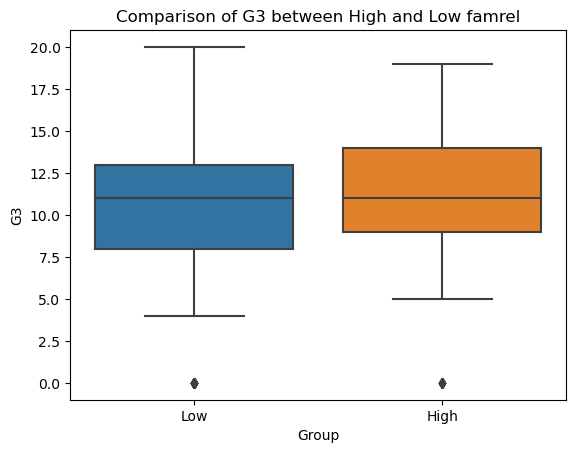

Column: studytime
T-Statistic: -2.1831, P-Value: 0.0307


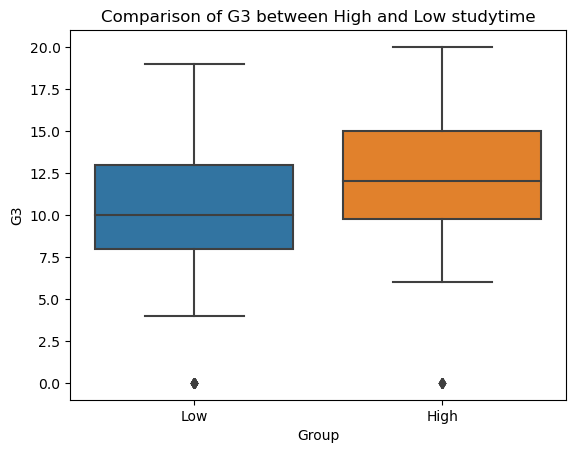

In [12]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path):
    """
    Load the student data from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    DataFrame: The loaded data.
    """
    return pd.read_csv(file_path)

def median_split(df, column):
    """
    Split the DataFrame into two groups based on the median of a specified column.

    Parameters:
    df (DataFrame): The input data.
    column (str): The column name to split the data.

    Returns:
    DataFrame, DataFrame: Low group and high group.
    """
    median_value = df[column].median()
    low_group = df[df[column] <= median_value]
    high_group = df[df[column] > median_value]
    return low_group, high_group

def perform_ttest(low_group, high_group, target_column):
    """
    Perform an independent t-test between two groups for a target column.

    Parameters:
    low_group (DataFrame): The low group data.
    high_group (DataFrame): The high group data.
    target_column (str): The column to test.

    Returns:
    tuple: t-statistic and p-value.
    """
    t_stat, p_val = stats.ttest_ind(low_group[target_column], high_group[target_column], equal_var=False)
    return t_stat, p_val

def visualize_groups(df, column, target_column):
    """
    Visualize the distribution of the target column for high and low groups.

    Parameters:
    df (DataFrame): The input data.
    column (str): The column used for splitting the data.
    target_column (str): The column to visualize.

    Returns:
    None
    """
    low_group, high_group = median_split(df, column)
    sns.boxplot(x='Group', y=target_column, data=pd.concat([
        low_group.assign(Group='Low'),
        high_group.assign(Group='High')
    ]))
    plt.title(f'Comparison of {target_column} between High and Low {column}')
    plt.show()

def analyze_significance(df, columns, target_column):
    """
    Analyze the significance of multiple columns against a target column.

    Parameters:
    df (DataFrame): The input data.
    columns (list): List of columns to analyze.
    target_column (str): The target column for comparison.

    Returns:
    None
    """
    results = {}
    for col in columns:
        low, high = median_split(df, col)
        t_stat, p_val = perform_ttest(low, high, target_column)
        results[col] = {'t_statistic': t_stat, 'p_value': p_val}
        print(f'Column: {col}')
        print(f'T-Statistic: {t_stat:.4f}, P-Value: {p_val:.4f}')
        visualize_groups(df, col, target_column)
    return results

def significance_tests():
    # Define the file path
    file_path = 'student_data.csv'
    
    # Load the data
    df = load_data(file_path)
    
    # Define the columns to analyze
    columns_to_analyze = ['failures', 'absences','age','health','freetime','goout','Walc','Fedu','Medu','famrel','studytime']
    target_column = 'G3'
    
    # Perform significance analysis
    results = analyze_significance(df, columns_to_analyze, target_column)
    
    # Optionally, you can save the results to a CSV file
    results_df = pd.DataFrame(results).T
    # results_df.to_csv('significance_results.csv')
    # print("Significance analysis complete. Results saved to 'significance_results.csv'.")

significance_tests()

# Uplift model

In [18]:
# Load the dataset
# Load the dataset
def load_data(filepath):
    """
    Load the student data from a CSV file.
    
    Parameters:
        filepath (str): The path to the CSV file.
    
    Returns:
        pd.DataFrame: Loaded data.
    """
    data = pd.read_csv(filepath)
    return data

# Preprocess the data
def preprocess_data(df):
    """
    Preprocess the data by dropping unnecessary columns and encoding categorical variables.
    
    Parameters:
        df (pd.DataFrame): The original dataframe.
    
    Returns:
        pd.DataFrame: Preprocessed dataframe.
    """
    # Drop 'G1' and 'G2' columns
    df = df.drop(['G1', 'G2'], axis=1)
    
    # Identify numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Exclude the target and treatment variables
    numeric_cols = [col for col in numeric_cols if col not in ['studytime', 'G3']]
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Define transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Fit and transform the data
    df_processed = preprocessor.fit_transform(df)
    
    # Get feature names after encoding
    encoded_cols = []
    if numeric_cols:
        encoded_cols += numeric_cols
    if categorical_cols:
        encoded_cols += preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()
    
    # Convert to DataFrame
    df_processed = pd.DataFrame(df_processed, columns=encoded_cols)
    
    # Add treatment and outcome variables
    df_processed['studytime'] = df['studytime']
    df_processed['G3'] = df['G3']
    
    return df_processed

def define_treatment_studytime(df):
    """
    Define the treatment variable based on 'studytime' as a binary variable.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['studytime'] > df['studytime'].median(), 1, 0)
    return df

def define_treatment_multiclass(df, thresholds=(1, 3)):
    """
    Define the treatment variable based on 'studytime' with multiple thresholds.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.
        thresholds (tuple): Thresholds to define treatment groups.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = pd.cut(
        df['studytime'],
        bins=[-np.inf, thresholds[0], thresholds[1], np.inf],
        labels=[0, 1, 2]
    )
    return df

def define_treatment_fail(df):
    """
    Define the treatment variable based on 'fail'.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['failures'] > df['failures'].median(), 1, 0)
    return df

def define_treatment_father_education(df):
    """
    Define the treatment variable based on 'Fedu'.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['Fedu'] > df['Fedu'].median(), 1, 0)
    return df

def define_treatment_mother_education(df):
    """
    Define the treatment variable based on 'Medu'.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['Medu'] > df['Medu'].median(), 1, 0)
    return df

def define_treatment_absences(df):
    """
    Define the treatment variable based on 'absences'.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['absences'] < df['absences'].median(), 1, 0)
    return df

def define_treatment_goout(df):
    """
    Define the treatment variable based on 'goout'.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['goout'] > df['goout'].median(), 1, 0)
    return df

def define_treatment_age(df):
    """
    Define the treatment variable based on 'age'.

    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.

    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['age'] < df['age'].median(), 1, 0)
    return df

def train_uplift_models(df, feature_cols, treatment_col='treatment', outcome_col='G3'):
    """
    Train separate XGBoost models for treatment and control groups.

    Parameters:
        df (pd.DataFrame): The dataframe with covariates, treatment, and outcome.
        feature_cols (list): List of feature column names.
        treatment_col (str): The treatment column name.
        outcome_col (str): The outcome column name.

    Returns:
        model_treated: Trained XGBoost model for treated group.
        model_control: Trained XGBoost model for control group.
    """
    # Split data into treated and control
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    X_treated = treated[feature_cols]
    y_treated = treated[outcome_col]
    
    X_control = control[feature_cols]
    y_control = control[outcome_col]
    
    # Define XGBoost regressor
    model_treated = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model_control = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Train models
    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)
    
    return model_treated, model_control

def predict_uplift(model_treated, model_control, X):
    """
    Predict uplift by taking the difference between treated and control model predictions.

    Parameters:
        model_treated: Trained XGBoost model for treated group.
        model_control: Trained XGBoost model for control group.
        X (pd.DataFrame): Feature matrix.

    Returns:
        pd.Series: Predicted uplift values.
    """
    pred_treated = model_treated.predict(X)
    pred_control = model_control.predict(X)
    uplift = pred_treated - pred_control
    return pd.Series(uplift, index=X.index)

def visualize_uplift(uplift, treatment_name='Uplift'):
    """
    Visualize the distribution of uplift scores.

    Parameters:
        uplift (pd.Series): Uplift scores.
        treatment_name (str): Name of the treatment variable.

    Returns:
        None
    """
    plt.figure(figsize=(8,6))
    sns.histplot(uplift, kde=True, bins=30)
    plt.xlabel('Uplift Score')
    plt.ylabel('Frequency')
    plt.title(f'{treatment_name.capitalize()} Uplift Score Distribution')
    plt.show()

def run_uplift_model(filepath, treatment_def_func=define_treatment_absences, n_bins=10):
    """
    Run the Uplift Model workflow using XGBoost with the Two-Model Approach.

    Parameters:
        filepath (str): The path to the CSV file.
        treatment_def_func (function): Function to define the treatment variable.
        n_bins (int): Number of bins for Qini coefficient calculation.

    Returns:
        None
    """
    # Load data
    df = load_data(filepath)

    # Preprocess data
    df_processed = preprocess_data(df)

    # Define treatment variable
    df_processed = treatment_def_func(df_processed)

    # If the treatment variable is defined as multi-category, choose one category for uplift modeling
    # Here we assume the treatment variable is binary; if multi-category, make adjustments as needed
    if df_processed['treatment'].dtype.name == 'category':
        # Example: Select category 1 as the primary treatment group, equivalent to binary
        df_processed = df_processed[df_processed['treatment'].isin([1])]
        df_processed['treatment'] = df_processed['treatment'].astype(int)

    # Define feature columns (exclude treatment and outcome variables)
    feature_cols = df_processed.columns.drop(['treatment', 'G3']).tolist()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        df_processed[feature_cols],
        df_processed['G3'],
        df_processed['treatment'],
        test_size=0.3,
        random_state=42
    )

    # Combine training data
    train_df = X_train.copy()
    train_df['G3'] = y_train
    train_df['treatment'] = treat_train

    # Train uplift models
    model_treated, model_control = train_uplift_models(train_df, feature_cols)

    # Predict uplift scores
    uplift = predict_uplift(model_treated, model_control, X_test)
    print(f'Average Uplift Score: {uplift.mean():.4f}')
    
    # Extract treatment name from the function name
    func_name = treatment_def_func.__name__
    # Assuming the function name is in the format 'define_treatment_<variable>'
    if func_name.startswith('define_treatment_'):
        treatment_variable = func_name.replace('define_treatment_', '')
    else:
        treatment_variable = 'Uplift'
    
    # Visualize uplift distribution with treatment name
    visualize_uplift(uplift, treatment_name=treatment_variable)


Average Uplift Score: 0.5071


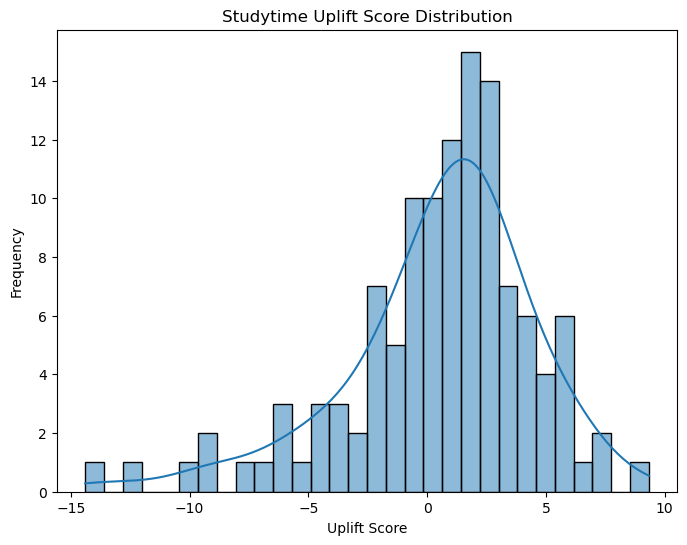

Average Uplift Score: -3.7623


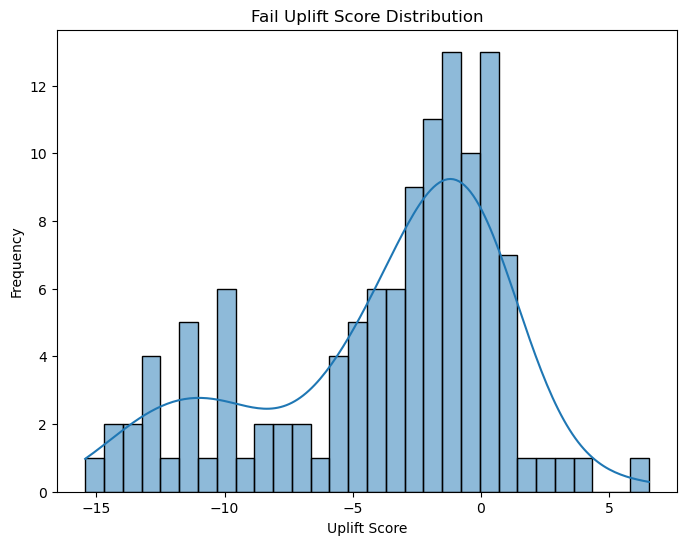

Average Uplift Score: -0.3509


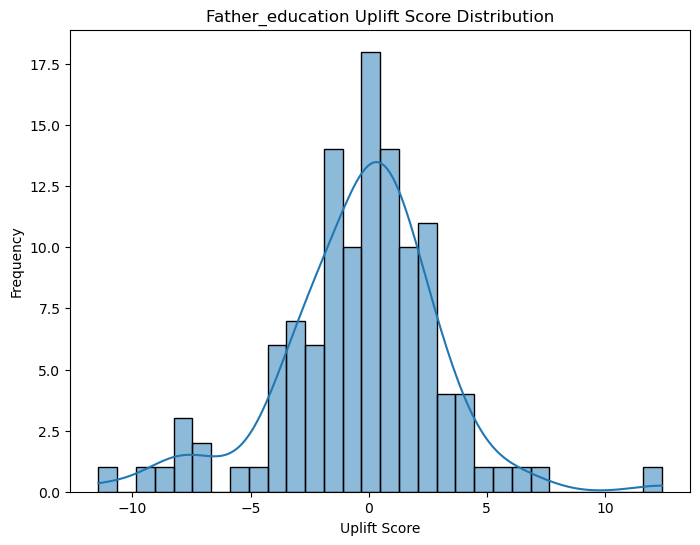

Average Uplift Score: 0.8615


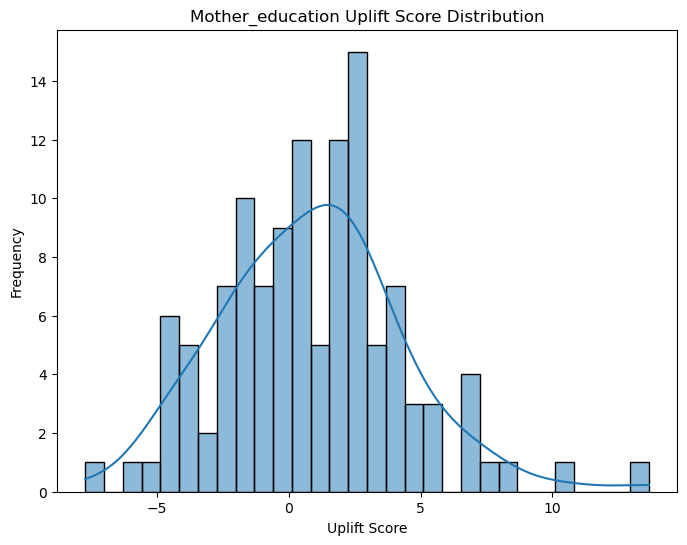

Average Uplift Score: -0.9406


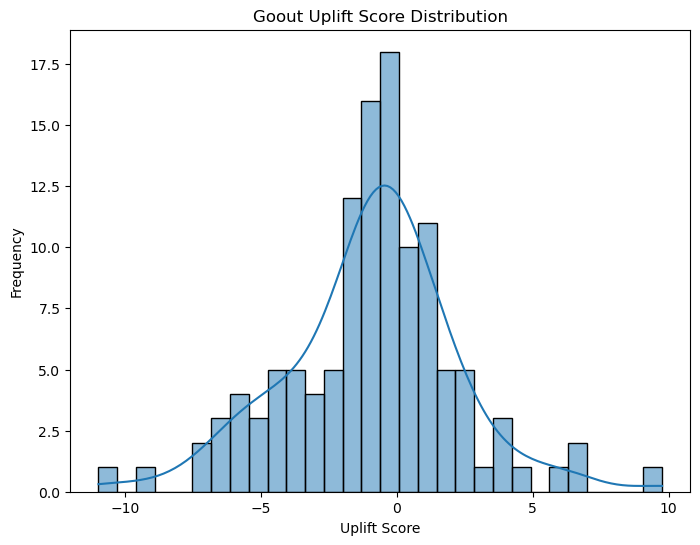

Average Uplift Score: 1.7631


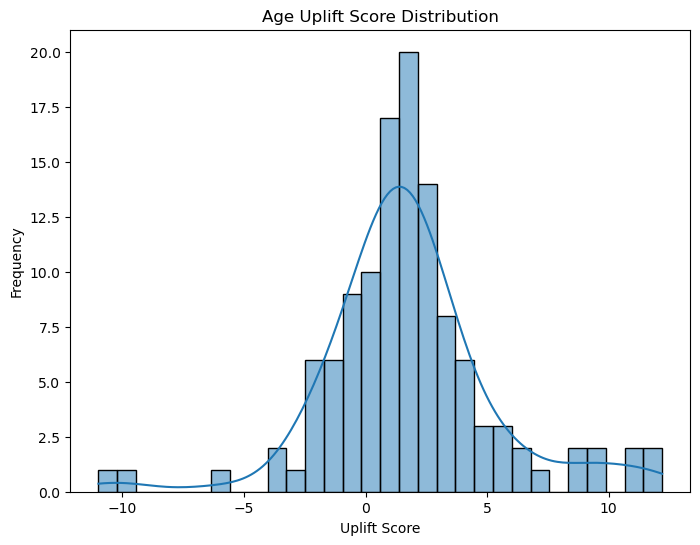

In [20]:
run_uplift_model(
    filepath=filepath,
    treatment_def_func=define_treatment_studytime,
    n_bins=10
)

run_uplift_model(
    filepath=filepath,
    treatment_def_func=define_treatment_fail,
    n_bins=10
)

run_uplift_model(
    filepath=filepath,
    treatment_def_func=define_treatment_father_education,
    n_bins=10
)

run_uplift_model(
    filepath=filepath,
    treatment_def_func=define_treatment_mother_education,
    n_bins=10
)

run_uplift_model(
    filepath=filepath,
    treatment_def_func=define_treatment_goout,
    n_bins=10
)

run_uplift_model(
    filepath=filepath,
    treatment_def_func=define_treatment_age,
    n_bins=10
)